## NLM Denoising Codec
Sistemas Multimedia
Autores:
Rafael de Jesús Bautista Hernández  
Saúl David Ramos Pacheco  
Alex César Taquila Camasca

## Explicacion Teorica
El filtro NLM (Non‑Local Means) es un método de eliminación de ruido basado en la similitud entre parches de la imagen.  
A diferencia de los filtros locales (como el promedio o el gaussiano), NLM compara cada píxel con una vecindad más amplia, buscando regiones similares en toda el área local.

Conceptos clave:
- Patch similarity: se compara un parche alrededor del píxel objetivo con parches vecinos.
- Spatial weighting: los píxeles más cercanos tienen mayor peso (similar al filtro bilateral).
- Range weighting: los píxeles con valores similares tienen mayor influencia.
- Normalización: la salida es una media ponderada de los valores vecinos.

Aproximación utilizada en este proyecto

Para reducir el coste computacional, se implementa una aproximación bilateral:

- Se usa una ventana fija de tamaño 5×5.
- Se calcula un peso espacial (gaussiano) y un peso de rango (diferencia de intensidad).
- Se aplica canal por canal (RGB).
- El resultado es una imagen suavizada con preservación de bordes. 

In [1]:
%%writefile ../src/NLM.py
import os
import argparse
import numpy as np
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr

# ==========================
#   RUTAS BASE
# ==========================

BASE_DIR    = "/tmp/NLM"
FRAMES_DIR  = os.path.join(BASE_DIR, "frames")
COMP_DIR    = os.path.join(BASE_DIR, "compressed")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

# ==========================
#   UTILIDADES
# ==========================

def load_image(path):
    img = Image.open(path).convert("RGB")
    return np.array(img, dtype=np.float32) / 255.0

def save_image(arr, path):
    arr8 = (np.clip(arr, 0.0, 1.0) * 255.0).astype(np.uint8)
    Image.fromarray(arr8).save(path)

# ==========================
#   NLM (APROX BILATERAL)
# ==========================

def nlm_fast(image, sigma_s=2.0, sigma_r=0.1):
    H, W, C = image.shape
    out = np.zeros_like(image)

    k = 5
    pad = k // 2
    padded = np.pad(image, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')

    y, x = np.mgrid[-pad:pad+1, -pad:pad+1]
    spatial = np.exp(-(x*x + y*y) / (2 * sigma_s * sigma_s))

    for c in range(C):
        channel = padded[:, :, c]
        out_c = np.zeros((H, W))

        for i in range(H):
            for j in range(W):
                region = channel[i:i+k, j:j+k]
                diff = region - channel[i+pad, j+pad]
                range_w = np.exp(-(diff*diff) / (2 * sigma_r * sigma_r))
                weights = spatial * range_w
                out_c[i, j] = np.sum(weights * region) / np.sum(weights)

        out[:, :, c] = out_c

    return out

# ==========================
#   ENCODER
# ==========================

def encoder_main():
    os.makedirs(COMP_DIR, exist_ok=True)

    files = sorted([f for f in os.listdir(FRAMES_DIR) if f.endswith(".png")])

    frame_index = 20
    if frame_index >= len(files):
        print("No existe el frame", frame_index)
        return

    f = files[frame_index]
    img = load_image(os.path.join(FRAMES_DIR, f))

    out_path = os.path.join(COMP_DIR, f.replace(".png", ".npz"))
    np.savez(out_path, image=img)

    print(f"Imagen comprimida (solo frame {frame_index}): {out_path}")

# ==========================
#   DECODER
# ==========================

def decoder_main():
    os.makedirs(RESULTS_DIR, exist_ok=True)

    comp_files = sorted([f for f in os.listdir(COMP_DIR) if f.endswith(".npz")])

    if len(comp_files) == 0:
        print("No hay archivos comprimidos")
        return

    f = comp_files[0]

    data = np.load(os.path.join(COMP_DIR, f), allow_pickle=True)
    img = data["image"]

    den = nlm_fast(img)

    out_path = os.path.join(RESULTS_DIR, f.replace(".npz", "_nlm.png"))
    save_image(den, out_path)

    print(f"NLM aplicado: {out_path}")

# ==========================
#   TEST
# ==========================

def test_main():
    orig_files = sorted([f for f in os.listdir(FRAMES_DIR) if f.endswith(".png")])
    nlm_files  = sorted([f for f in os.listdir(RESULTS_DIR) if f.endswith("_nlm.png")])

    if len(nlm_files) == 0:
        print("No hay imágenes NLM para comparar")
        return

    orig_path = os.path.join(FRAMES_DIR, orig_files[20])
    nlm_path  = os.path.join(RESULTS_DIR, nlm_files[0])

    img_o = load_image(orig_path)
    img_n = load_image(nlm_path)

    p = psnr(img_o, img_n)
    print(f"PSNR frame 20 = {p:.2f} dB")

# ==========================
#   COMPARACION
# ==========================

def compare_main():
    orig_files = sorted([f for f in os.listdir(FRAMES_DIR) if f.endswith(".png")])
    nlm_files  = sorted([f for f in os.listdir(RESULTS_DIR) if f.endswith("_nlm.png")])

    if len(nlm_files) == 0:
        print("No hay imágenes NLM para comparar")
        return

    orig_path = os.path.join(FRAMES_DIR, orig_files[20])
    nlm_path  = os.path.join(RESULTS_DIR, nlm_files[0])

    print("Original:", orig_path)
    print("NLM:", nlm_path)

# ==========================
#   CLI
# ==========================

def main():
    parser = argparse.ArgumentParser(description="NLM codec (solo frame 20)")
    subparsers = parser.add_subparsers(dest="command", required=True)

    subparsers.add_parser("encode")
    subparsers.add_parser("decode")
    subparsers.add_parser("test")
    subparsers.add_parser("compare")

    args = parser.parse_args()

    if args.command == "encode":
        encoder_main()
    elif args.command == "decode":
        decoder_main()
    elif args.command == "test":
        test_main()
    elif args.command == "compare":
        compare_main()

if __name__ == "__main__":
    main()

Writing ../src/NLM.py


In [2]:
import os
import shutil

BASE_DIR    = "/tmp/NLM"
FRAMES_DIR  = os.path.join(BASE_DIR, "frames")
COMP_DIR    = os.path.join(BASE_DIR, "compressed")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)

os.makedirs(FRAMES_DIR, exist_ok=True)
os.makedirs(COMP_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Estructura creada en:", BASE_DIR)

Estructura creada en: /tmp/NLM


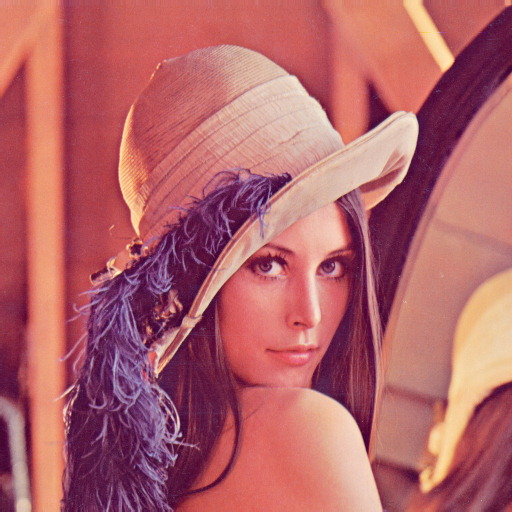

In [3]:
import requests
from PIL import Image
from io import BytesIO

url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")
img.save("/tmp/input.png")

img

In [4]:
from PIL import Image
import numpy as np
import os

img = Image.open("/tmp/input.png").convert("RGB")
arr = np.array(img)

N_FRAMES = 30  

for i in range(N_FRAMES):
    Image.fromarray(arr).save(os.path.join(FRAMES_DIR, f"frame_{i:03d}.png"))

print("Frames generados:", len(os.listdir(FRAMES_DIR)))

Frames generados: 30


In [5]:
!python ../src/NLM.py encode
!python ../src/NLM.py decode
!python ../src/NLM.py test
!python ../src/NLM.py compare

Imagen comprimida (solo frame 20): /tmp/NLM/compressed/frame_020.npz
NLM aplicado: /tmp/NLM/results/frame_020_nlm.png
PSNR frame 20 = 35.40 dB
Original: /tmp/NLM/frames/frame_020.png
NLM: /tmp/NLM/results/frame_020_nlm.png


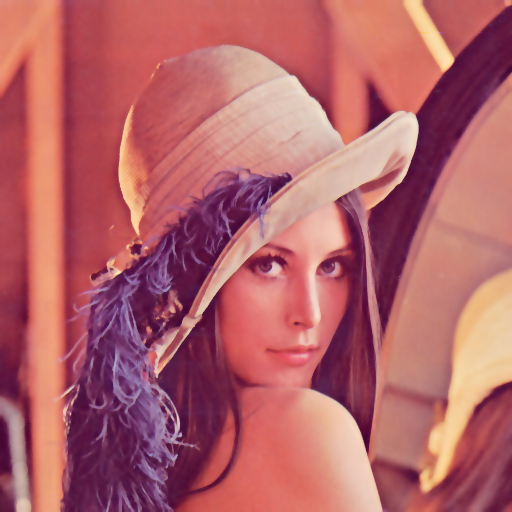

In [6]:
from IPython.display import Image as IPyImage, display
import os

nlm_files = sorted([f for f in os.listdir(RESULTS_DIR) if f.endswith("_nlm.png")])

if nlm_files:
    display(IPyImage(filename=os.path.join(RESULTS_DIR, nlm_files[0])))
else:
    print("No se encontró imagen NLM")

## Comparacion

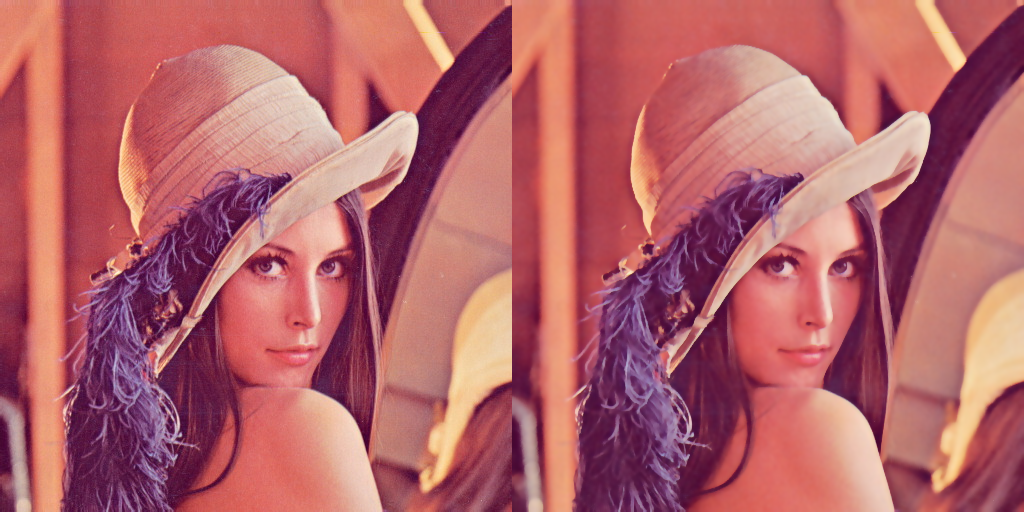

In [7]:
from PIL import Image
import numpy as np

orig_path = os.path.join(FRAMES_DIR, "frame_020.png")
nlm_path  = os.path.join(RESULTS_DIR, nlm_files[0])

orig = np.array(Image.open(orig_path).convert("RGB"))
nlm  = np.array(Image.open(nlm_path).convert("RGB"))

concat = np.hstack((orig, nlm))
display(Image.fromarray(concat))